# Validation of autoencoder task + Prediction

In [1]:
# load custom packages from src dir
import sys
sys.path.insert(0, '..')

# python packages
import logging
import os
import time
import numpy as np
import pandas as pd
import torch

# Viz
import matplotlib.pyplot as plt
%matplotlib inline

# custom packages
import src.commons.dataset as ds
import src.commons.constants as cons

# U-Net custom implementation
from src.models.u_net import *

# Define the logging level
logging.getLogger().setLevel(logging.INFO)

## Load the model

In [2]:
CHECKPOINT_PATH = ".." + cons.DIR_SEP + os.path.join("results")
CHECKPOINT_PATH = os.path.join(CHECKPOINT_PATH, 'autoencoder_models')
CATEGORY = 'hazelnut'
resize_dim = 200
PATH = os.path.join(CHECKPOINT_PATH, f"autoencoder_{CATEGORY}_resizedim_{resize_dim}.pt")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
model = SegmentationNetwork(n_channels=3, n_classes=3).to(DEVICE)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Load test data

In [4]:
test_data = load_test_data(CATEGORY, batch_size=4)

In [5]:
test_data

{'dataset': <src.commons.dataset.MVTECTestDataset at 0x105dc48b0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x14b477dc0>}

## Model Prediction

In [6]:
def predict(model, data_loader, **kwargs):
    device = kwargs.get("device", torch.device("cpu"))
    resize_dim = kwargs.get("resize_dim", 200)
    
    input_imgs, recon_images, targets,  = [], [], []

    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for i, batch in pbar:

        logging.debug(f"Inputs : {batch['test'].shape}, {batch['test'].dtype}")

        resize = transforms.Resize(resize_dim)
        inputs = resize(batch["test"]) / 255.0
        inputs = inputs.to(device)
        
        logging.debug(f"Inputs : {inputs.shape}, {inputs.dtype}")


        model.zero_grad() # initialize gradients to zero
        with torch.no_grad():
            recons = model(inputs)
        
        input_imgs.append(inputs)
        recon_images.append(recons)
        targets.append(resize(batch["ground_truth"]) / 255.0)

    return torch.stack(input_imgs[:-1]), torch.stack(recon_images[:-1]), torch.stack(targets[:-1])

In [7]:
inputs, recons, targets = predict(model, test_data['test'], resize_dim=resize_dim)

100%|██████████| 28/28 [00:20<00:00,  1.38it/s]


## Viz

In [8]:
inputs_resh = einops.rearrange(inputs, "n b c h w -> (n b) h w c")
recons_resh = einops.rearrange(recons, "n b c h w -> (n b) h w c")
targets_resh = einops.rearrange(targets, "n b c h w -> (n b) h w c")

In [9]:
def get_plot(inputs, recons, targets, idx, threshold=0.5):
    scores = np.sqrt(((inputs[idx] - recons[idx])**2).sum(-1)) # anomaly mask
    scores = (scores - scores.min())/(scores.max() - scores.min()) # Normalize scores
    score_bin = np.where(scores > threshold, 1, 0) # Threshold scores

    fig, axs = plt.subplots(1, 5, figsize=(8, 8))
    axs[0].imshow(inputs[idx])
    axs[0].set_title('Raw image')
    axs[0].axis('off')
    axs[1].imshow(recons[idx])
    axs[1].set_title('Generated image')
    axs[1].axis('off')
    axs[2].imshow(scores)
    axs[2].set_title('Score map')
    axs[2].axis('off')
    axs[3].imshow(score_bin)
    axs[3].set_title('Score map binary')
    axs[3].axis('off')
    axs[4].imshow(targets[idx])
    axs[4].set_title('Target')
    axs[4].axis('off')
    fig.tight_layout()
    plt.show()

## Explore SSIM

In [10]:
import torchmetrics
from torchvision.transforms.functional import to_pil_image
from torchmetrics.functional import structural_similarity_index_measure

In [11]:
def build_image_patches_and_compute_ssim(patch_size, inputs_resh, inputs, recons, targets, idx):
    img = inputs_resh[idx]
    img_bcwh = inputs[idx]
    rec_bcwh = recons[idx]
    img_patches = img.unfold(0, patch_size, patch_size).unfold(1, patch_size, patch_size) # W H C
    img_bcwh_patches = img_bcwh.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size) # B C W H
    rec_bcwh_patches = rec_bcwh.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size) # B C W H
    
    ssim_mask = []
    fig, ax = plt.subplots(img_patches.shape[0], img_patches.shape[1])
    for i in range(img_patches.shape[0]):
        ssim_mask_i = []
        for j in range(img_patches.shape[1]):
            sub_img = img_patches[i, j, :] # W D C
            sub_img_bcwh = img_bcwh_patches[:, :, i, j] # B C W H
            sub_rec_bcwh = rec_bcwh_patches[:, :, i, j] # B C W H
            ax[i][j].imshow(to_pil_image(sub_img))
            ax[i][j].axis('off')

            ssim_j = structural_similarity_index_measure(sub_rec_bcwh, sub_img_bcwh, data_range=1.0)
            ssim_mask_i.append(ssim_j)
        ssim_mask.append(ssim_mask_i)
    plt.show()
    return ssim_mask
    
    
def build_mask_image_with_tiles(patch_size, ssim_mask):
    data = np.zeros((0, 0, 3), dtype=np.uint8)
    for i in range(len(ssim_mask)):
        data_i = np.zeros((0, 0, 3), dtype=np.uint8)
        for j in range(len(ssim_mask[i])):
            tile = np.ones((patch_size, patch_size, 3), dtype=np.uint8) * ssim_mask[i][j].numpy()
            if data_i.shape[0] == 0:
                data_i = tile
            else:
                data_i = np.concatenate((data_i, tile), axis=0)
        if data.shape[0] == 0:
            data = data_i
        else:
            data = np.concatenate((data, data_i), axis=1)
    return data

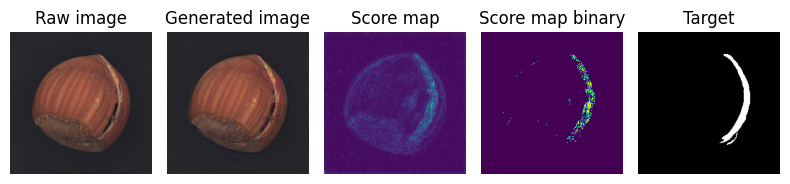

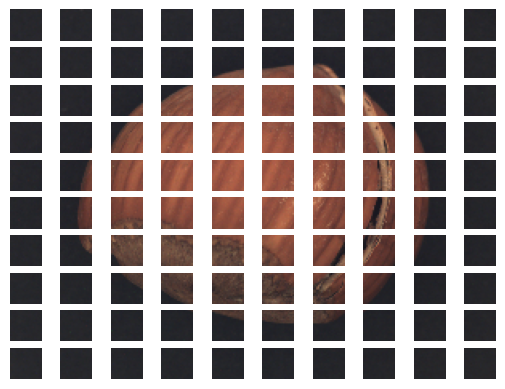

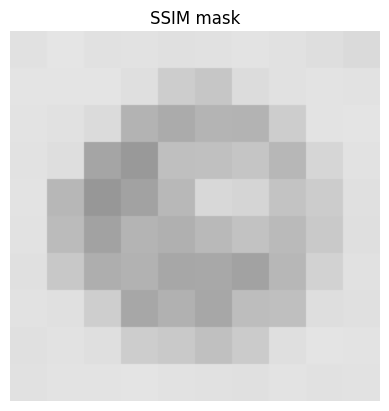

In [12]:
PATCH_SIZE = 20
idx = 1

# all the other plots
get_plot(inputs_resh, recons_resh, targets_resh, idx, threshold=0.3)

ssim_mask = build_image_patches_and_compute_ssim(PATCH_SIZE, inputs_resh, inputs, recons, targets, idx)

data = build_mask_image_with_tiles(PATCH_SIZE, ssim_mask)
plt.figure()
plt.imshow(data)
plt.axis('off')
plt.title(f"SSIM mask")
plt.show()

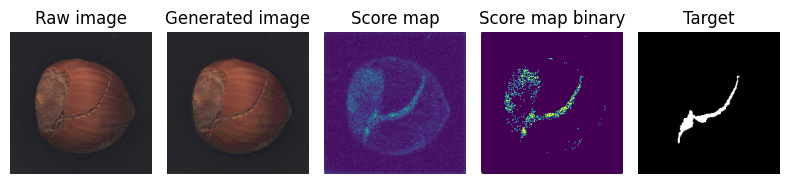

In [13]:
idx = 3

# all the other plots
get_plot(inputs_resh, recons_resh, targets_resh, idx, threshold=0.3)

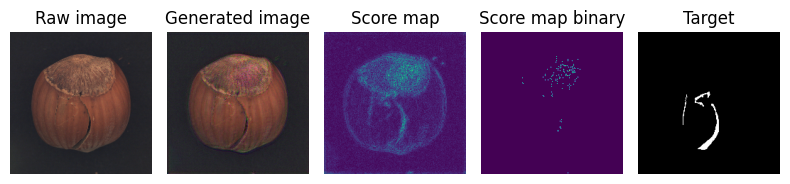

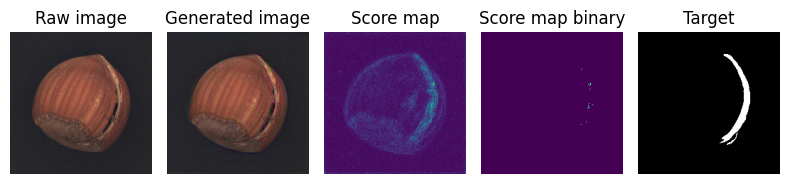

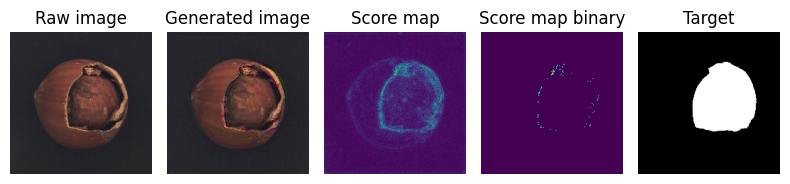

In [14]:
idx = 0
while idx < 3:
    get_plot(inputs_resh, recons_resh, targets_resh, idx, threshold=0.6)
    idx += 1
    

In [15]:
import cv2
import PIL

In [16]:
def get_scores(inputs, recons, idx, threshold=0.5):
    scores = np.sqrt(((inputs[idx] - recons[idx])**2).sum(-1)) # anomaly mask
    scores = (scores - scores.min())/(scores.max() - scores.min()) # Normalize scores
    scores_bin = np.where(scores > threshold, 1, 0) # Threshold scores
    return scores, scores_bin

In [44]:
threshold = 0.2
idx = 2
scores, scores_bin = get_scores(inputs_resh, recons_resh, idx, threshold=threshold)
print(scores.shape, scores_bin.shape)

im_scores = PIL.Image.fromarray(scores.numpy())

torch.Size([200, 200]) (200, 200)


In [59]:
# Threshold.
# Set values equal to or above 220 to 0.
# Set values below 220 to 255.
th, im_th = cv2.threshold(scores.numpy()*255, int(255*threshold), 255, cv2.THRESH_BINARY_INV)

# Copy the thresholded image.
im_floodfill = im_th.copy()

# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image.
flood_filling_px = 2
h, w = im_th.shape[:flood_filling_px]
mask = np.zeros((h+flood_filling_px, w+flood_filling_px), np.uint8)
 
# Floodfill from point (0, 0)
cv2.floodFill(im_floodfill, mask, (0,0), 255)
 
# Invert floodfilled image
im_floodfill_inv = cv2.bitwise_not(im_floodfill)

# Fill contours
des = cv2.bitwise_not(im_floodfill_inv)
print(des.shape)
contours, hierarchy = cv2.findContours(des, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    cv2.drawContours(des,[cnt],0,255,-1)

gray = cv2.bitwise_not(des)

# Combine the two images to get the foreground.
#im_out = im_th | im_floodfill_inv

im_out = cv2.bitwise_or(im_th, im_floodfill_inv)

# Display images.
plt.imshow(im_th, label="Thresholded Image")
plt.show()
plt.imshow(im_floodfill, label="Floodfilled Image")
plt.show()
plt.imshow(im_floodfill_inv, label="Inverted Floodfilled Image")
plt.show()
plt.imshow(gray, label="filling holes")
plt.show()
plt.imshow(im_out, label="Foreground")
plt.show()

(200, 200)
(200, 200)


error: OpenCV(4.6.0) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'
